In [1]:
#imports
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Permute
from tensorflow.keras.layers import Input, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Input, GlobalAveragePooling2D, ReLU, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Lambda
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#load cleaned data
loaded = np.load('/content/drive/MyDrive/ML data/mtg_data_balanced.npz', allow_pickle=True, mmap_mode='r')
X_train = loaded['X_train']
Y_train = loaded['Y_train']
X_test = loaded['X_test']
Y_test = loaded['Y_test']

In [8]:
#download y_test
np.save('/content/drive/MyDrive/ML data/y_test.npy', Y_test)

In [5]:
#save track IDs separately, just in case (ended up being used! woohoo!)
Y_test_ids = Y_test[:,0]
Y_train_ids = Y_train[:,0]
#convert all to float16
X_train = X_train.astype('float16')
X_test = X_test.astype('float16')
Y_train = Y_train[:, 1:].astype('float16')
Y_test = Y_test[:, 1:].astype('float16')

In [6]:
#download list of test ids
np.save('/content/drive/MyDrive/ML data/test_ids.npy', Y_test_ids)

In [ ]:
#confirm shapes
print(X_train.shape, Y_train.shape)

(11514, 96, 1400, 1) (11514, 10)


In [ ]:
#implement time and frequency masking
def spec_augment(batch_x, batch_y,
                 freq_mask_param=16,  #remove a vertical strip of up to 16
                 time_mask_param=64): #removera horizontal strip of up to 64

    def augment_single(x):
        #freqmask
        f = tf.random.uniform([], minval=0, maxval=freq_mask_param, dtype=tf.int32)
        f0 = tf.random.uniform([], minval=0, maxval=96 - f, dtype=tf.int32)
        freq_mask = tf.concat([
            tf.ones((f0, 1400, 1)),
            tf.zeros((f, 1400, 1)),
            tf.ones((96 - f0 - f, 1400, 1))
        ], axis=0)

        #timemask
        t = tf.random.uniform([], minval=0, maxval=time_mask_param, dtype=tf.int32)
        t0 = tf.random.uniform([], minval=0, maxval=1400 - t, dtype=tf.int32)
        time_mask = tf.concat([
            tf.ones((96, t0, 1)),
            tf.zeros((96, t, 1)),
            tf.ones((96, 1400 - t0 - t, 1))
        ], axis=1)

        #apply both to spectrogram
        x = x * freq_mask * time_mask
        return x

    batch_x = tf.map_fn(augment_single, batch_x)
    return batch_x, batch_y


In [ ]:
#make generators as to not overwhelm RAM
def train_generator(batch_size=32):
    n = X_train.shape[0]
    while True:
        idx = np.random.permutation(n)
        for start in range(0, n, batch_size):
            end = start + batch_size
            batch_idx = idx[start:end]
            yield X_train[batch_idx], Y_train[batch_idx]

def val_generator(batch_size=32):
    n = X_test.shape[0]
    while True:
        for start in range(0, n, batch_size):
            end = start + batch_size
            batch_idx = np.arange(start, min(end, n))
            yield X_test[batch_idx], Y_test[batch_idx]

batch_size = 16

train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator(batch_size),
    output_signature=(
        tf.TensorSpec(shape=(None, *X_train.shape[1:]), dtype=tf.float32),
        tf.TensorSpec(shape=(None, *Y_train.shape[1:]), dtype=tf.float32)
    )
)

#apply spec augment to only training data
train_dataset = train_dataset.map(spec_augment, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_generator(batch_size),
    output_signature=(
        tf.TensorSpec(shape=(None, *X_test.shape[1:]), dtype=tf.float32),
        tf.TensorSpec(shape=(None, *Y_test.shape[1:]), dtype=tf.float32)
    )
)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

After much experimentation, three model architectures were attempted. These three architectures were inspired by [a paper by Johnathan Mendes](https://norma.ncirl.ie/4455/1/jonathanmendes.pdf), who was also trying to classify genres with neural networks.

10 class CNN-biLSTM

In [ ]:
model = Sequential([
    Input(shape=(96, 1400, 1)),

    #start with convolutional and max pooling layers
    Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2,2)),  # 96x1400 → 48x700

    Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.01)),
    BatchNormalization(),

    #flatten and feed into bidirectional LSTM
    Lambda(lambda t: tf.reduce_mean(t, axis=1)),

    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),

    Dense(10, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    #reduce LR on plateau is more effective than early stopping, allows model to learn more
    keras.callbacks.ReduceLROnPlateau(
        factor=0.5, patience=2, min_lr=1e-5, verbose=1
    ),
    #early stopping as backup to stop overfitting
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    #save progress because colab limits can be the proverbial female dog
    keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/ML data/spec_model_10class.keras',     # or .h5 if you prefer
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
    )
]


steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_test) // batch_size

history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.2229 - loss: 3.2828
Epoch 1: val_accuracy improved from -inf to 0.15054, saving model to /content/drive/MyDrive/ML data/spec_model_10class.keras
719/719 ━━━━━━━━━━━━━━━━━━━━ 265s 349ms/step - accuracy: 0.2229 - loss: 3.2818 - val_accuracy: 0.1505 - val_loss: 2.5840 - learning_rate: 0.0010
Epoch 2/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.2308 - loss: 2.2534
Epoch 2: val_accuracy improved from 0.15054 to 0.15289, saving model to /content/drive/MyDrive/ML data/spec_model_10class.keras
719/719 ━━━━━━━━━━━━━━━━━━━━ 255s 353ms/step - accuracy: 0.2308 - loss: 2.2534 - val_accuracy: 0.1529 - val_loss: 2.3720 - learning_rate: 0.0010
Epoch 3/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.2388 - loss: 2.5509
Epoch 3: val_accuracy did not improve from 0.15289
719/719 ━━━━━━━━━━━━━━━━━━━━ 254s 353ms/step - accuracy: 0.2388 - loss: 2.5506 - val_accuracy: 0.1226 - val_loss: 2.6105 - learning_rate: 0.00

best accuracy acheived on vaildation: 0.4654

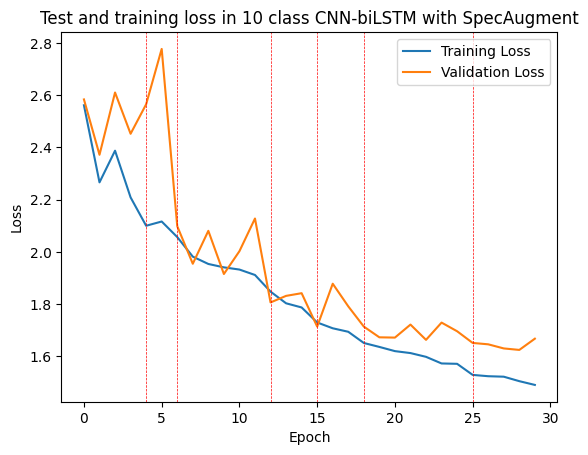

In [ ]:
#display graph of training and testing loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
#add vertical lines when LR was reduced
decreased = [4, 6, 12, 15, 18, 25]
for epoch in decreased:
    plt.axvline(x=epoch, color='r', linestyle='--', lw=0.5)
plt.title('Test and training loss in 10 class CNN-biLSTM with SpecAugment')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

747/747 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step


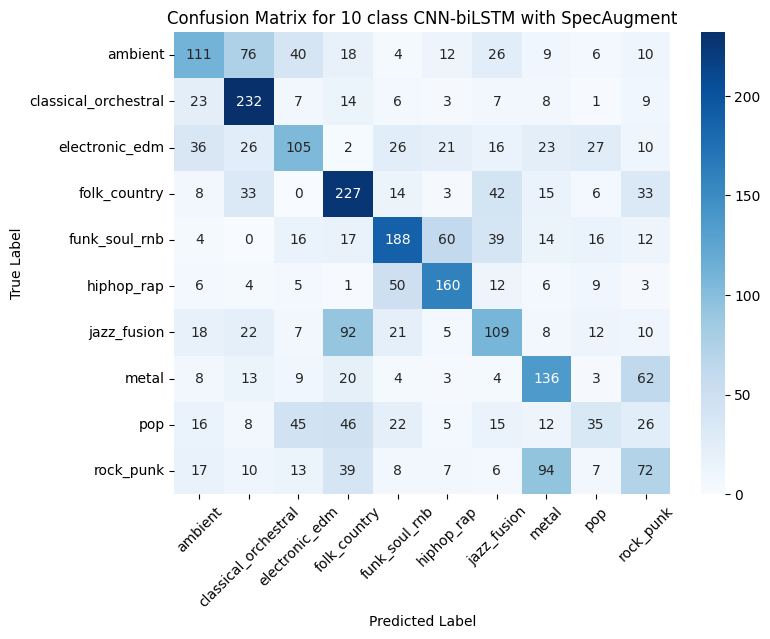

In [ ]:
#plot confusion matrix of results
#y_test_pred = model.predict(X_test)
test_ds = tf.data.Dataset.from_tensor_slices(X_test).batch(4)
y_test_pred = model.predict(test_ds)
test_predicted = np.argmax(y_test_pred, axis=1)
test_true = np.argmax(Y_test, axis=1)

genres = ['ambient',
          'classical_orchestral',
          'electronic_edm',
          'folk_country',
          'funk_soul_rnb',
          'hiphop_rap',
          'jazz_fusion',
          'metal',
          'pop',
          'rock_punk']

cm = confusion_matrix(test_true, test_predicted)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=np.arange(len(genres))+0.5, labels=genres, rotation=45)
plt.yticks(ticks=np.arange(len(genres))+0.5, labels=genres, rotation=0)
plt.title('Confusion Matrix for 10 class CNN-biLSTM with SpecAugment')
plt.show()

10 class CNN-LSTM

In [ ]:
model = Sequential([
    Input(shape=(96, 1400, 1)),

    Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2,2)),  # 96x1400 → 48x700

    Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.01)),
    BatchNormalization(),

    Lambda(lambda t: tf.reduce_mean(t, axis=1)),

    #slightly different than the first one, not bidirectional
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),

    Dense(10, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        factor=0.5, patience=2, min_lr=1e-5, verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/ML data/cnnlstm_10class.keras',     # or .h5 if you prefer
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
    )
]


steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_test) // batch_size

history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.2148 - loss: 3.3006
Epoch 1: val_accuracy improved from -inf to 0.13710, saving model to /content/drive/MyDrive/ML data/cnnlstm_10class.keras
719/719 ━━━━━━━━━━━━━━━━━━━━ 248s 329ms/step - accuracy: 0.2148 - loss: 3.2996 - val_accuracy: 0.1371 - val_loss: 2.5984 - learning_rate: 0.0010
Epoch 2/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.2385 - loss: 2.2575
Epoch 2: val_accuracy improved from 0.13710 to 0.21405, saving model to /content/drive/MyDrive/ML data/cnnlstm_10class.keras
719/719 ━━━━━━━━━━━━━━━━━━━━ 238s 329ms/step - accuracy: 0.2385 - loss: 2.2575 - val_accuracy: 0.2140 - val_loss: 2.2551 - learning_rate: 0.0010
Epoch 3/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.2211 - loss: 2.3674
Epoch 3: val_accuracy did not improve from 0.21405
719/719 ━━━━━━━━━━━━━━━━━━━━ 236s 328ms/step - accuracy: 0.2211 - loss: 2.3674 - val_accuracy: 0.1542 - val_loss: 2.5753 - learning_rate: 0.0010
Epo

best accuracy acheived on validation: 0.4432

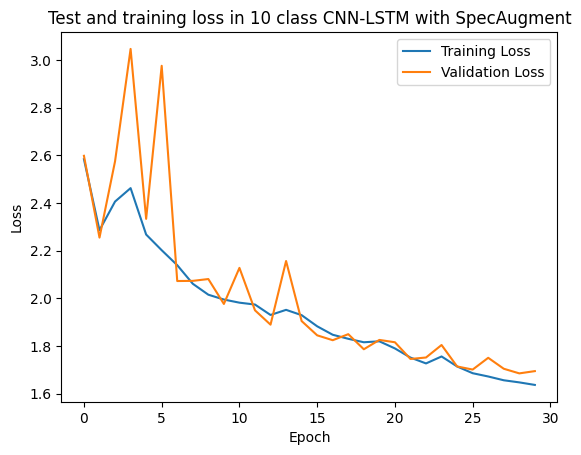

In [ ]:
#display graph of training and testing loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Test and training loss in 10 class CNN-LSTM with SpecAugment')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

747/747 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step


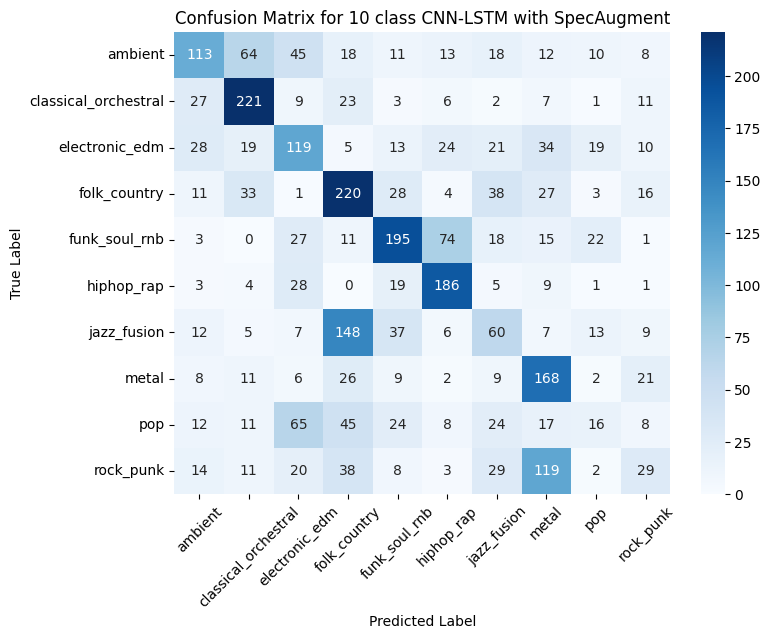

In [ ]:
#plot confusion matrix of results
#y_test_pred = model.predict(X_test)
test_ds = tf.data.Dataset.from_tensor_slices(X_test).batch(4)
y_test_pred = model.predict(test_ds)
test_predicted = np.argmax(y_test_pred, axis=1)
test_true = np.argmax(Y_test, axis=1)

genres = ['ambient',
          'classical_orchestral',
          'electronic_edm',
          'folk_country',
          'funk_soul_rnb',
          'hiphop_rap',
          'jazz_fusion',
          'metal',
          'pop',
          'rock_punk']

cm = confusion_matrix(test_true, test_predicted)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=np.arange(len(genres))+0.5, labels=genres, rotation=45)
plt.yticks(ticks=np.arange(len(genres))+0.5, labels=genres, rotation=0)
plt.title('Confusion Matrix for 10 class CNN-LSTM with SpecAugment')
plt.show()

10 class deep pure CNN

In [ ]:
model = Sequential([
    Input(shape=(96, 1400, 1)),

    Conv2D(32, (3,3), padding="same"),
    BatchNormalization(),
    ReLU(),
    #output of 96 x 1400 x 32
    Conv2D(32, (3,3), padding="same"),
    BatchNormalization(),
    ReLU(),
    #output of 96 x 1400 x 32
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),
    #output of 48 x 700 x 32

    Conv2D(64, (5,5), padding="same"),
    BatchNormalization(),
    ReLU(),
    #output of 48 x 700 x 64
    Conv2D(64, (5,5), padding="same"),
    BatchNormalization(),
    ReLU(),
    #output of 48 x 700 x 64
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),
    #output of 24 x 350 x 64

    Conv2D(128, (3,3), padding="same"),
    BatchNormalization(),
    ReLU(),
    #output of 24 x 350 x 128
    Conv2D(128, (3,3), padding="same"),
    BatchNormalization(),
    ReLU(),
    #output of 24 x 350 x 128
    MaxPooling2D(pool_size=(3,3)),
    Dropout(0.3),
    #output of 8 x 116 x 128

    Conv2D(256, (3,3), padding="same"),
    BatchNormalization(),
    ReLU(),
    #output of 8 x 116 x 256
    Conv2D(256, (3,3), padding="same"),
    BatchNormalization(),
    ReLU(),
    #output of 8 x 116 x 256
    GlobalAveragePooling2D(),
    Dropout(0.4),
    #output of 256

    Dense(256, activation="relu"),
    Dropout(0.4),
    Dense(10, activation="softmax")
])


In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        factor=0.5, patience=2, min_lr=1e-5, verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/ML data/purecnn_10class.keras',     # or .h5 if you prefer
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
    )
]


steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_test) // batch_size

history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.2204 - loss: 2.1392
Epoch 1: val_accuracy improved from -inf to 0.26512, saving model to /content/drive/MyDrive/ML data/purecnn_10class.keras
719/719 ━━━━━━━━━━━━━━━━━━━━ 250s 286ms/step - accuracy: 0.2204 - loss: 2.1391 - val_accuracy: 0.2651 - val_loss: 2.0195 - learning_rate: 0.0010
Epoch 2/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.3075 - loss: 1.9225
Epoch 2: val_accuracy did not improve from 0.26512
719/719 ━━━━━━━━━━━━━━━━━━━━ 230s 285ms/step - accuracy: 0.3075 - loss: 1.9225 - val_accuracy: 0.2349 - val_loss: 2.3814 - learning_rate: 0.0010
Epoch 3/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.3378 - loss: 1.8469
Epoch 3: val_accuracy improved from 0.26512 to 0.35282, saving model to /content/drive/MyDrive/ML data/purecnn_10class.keras
719/719 ━━━━━━━━━━━━━━━━━━━━ 205s 285ms/step - accuracy: 0.3378 - loss: 1.8468 - val_accuracy: 0.3528 - val_loss: 1.8263 - learning_rate: 0.0010
Epo

best accuracy acheived on validation: 0.4798- best of all three based on this metric alone

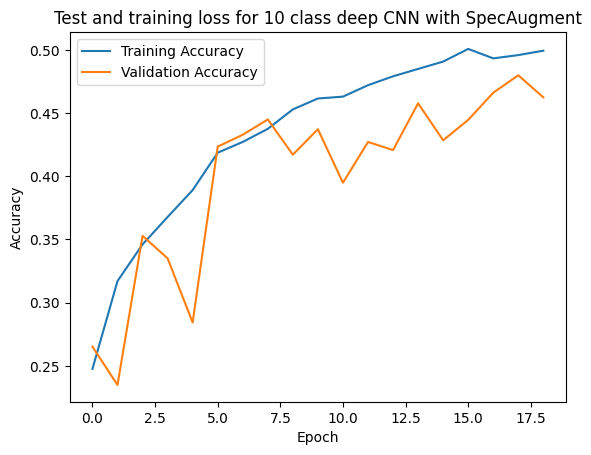

In [ ]:
#use history to visualize test and training loss
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test and training loss for 10 class deep CNN with SpecAugment')
plt.legend()
plt.show()

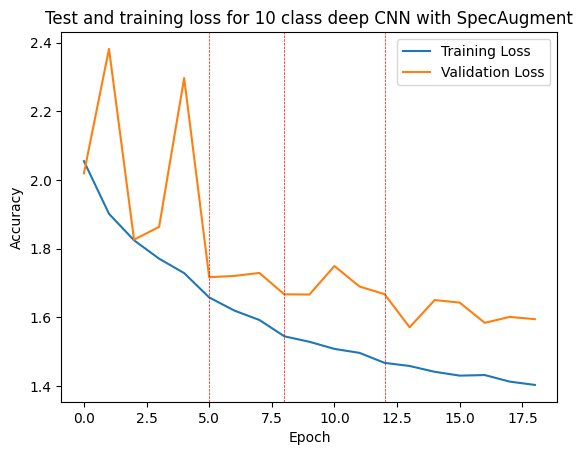

In [ ]:
#use history to visualize test and training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
#add vertical lines when LR was reduced
decreased = [5, 8, 12]
for epoch in decreased:
    plt.axvline(x=epoch, color='r', linestyle='--', lw=0.5)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test and training loss for 10 class deep CNN with SpecAugment')
plt.legend()
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 123ms/step


Text(0.5, 1.0, 'Confusion Matrix for 10 class CNN with SpecAugment')

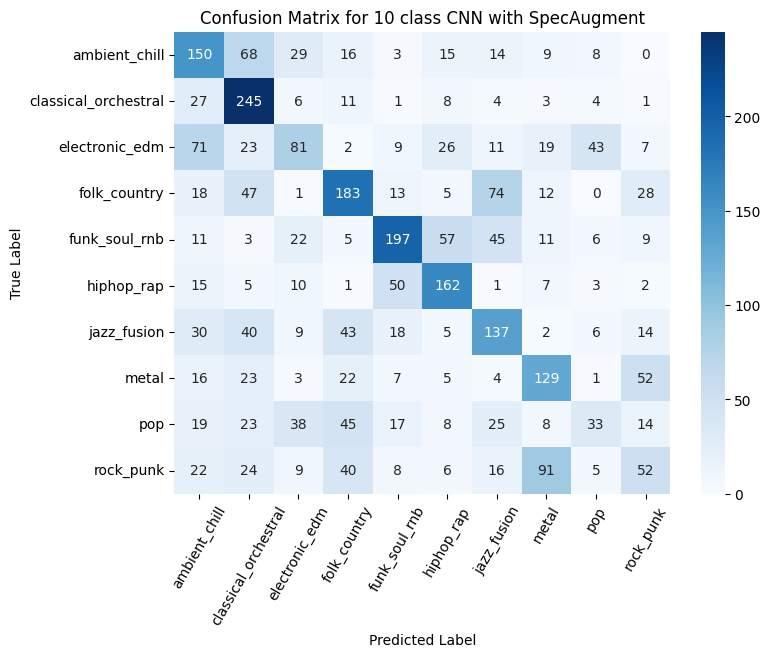

In [ ]:
y_test_pred = model.predict(X_test)
test_predicted = np.argmax(y_test_pred, axis=1)
test_true = np.argmax(Y_test, axis=1)

genres = ['ambient_chill',
          'classical_orchestral',
          'electronic_edm',
          'folk_country',
          'funk_soul_rnb',
          'hiphop_rap',
          'jazz_fusion',
          'metal',
          'pop',
          'rock_punk']

cm = confusion_matrix(test_true, test_predicted)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=np.arange(len(genres))+0.5, labels=genres, rotation=60)
plt.yticks(ticks=np.arange(len(genres))+0.5, labels=genres, rotation=0)
plt.title('Confusion Matrix for 10 class CNN with SpecAugment')